<a href="https://colab.research.google.com/github/gtrofimiuk/ML_course/blob/HW2/MusicGenres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre/data

Датасет есть в репозитории, его надо положить в папку sample_data/prediction-of-music-genre

In [121]:
import os
os.makedirs("sample_data/prediction-of-music-genre", 0o777, exist_ok=True)

In [122]:
!pip install --upgrade matplotlib > None
# need refresh enviroment after installation

In [123]:
!pip install feature_engine > None

In [124]:
!pip install seaborn > None

In [125]:
!pip install graphviz > None

In [126]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import feature_engine

import math

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
#from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# Данные

Набор данных состоит из различных параметров музыкальных треков

In [127]:
dataset_path = "sample_data/prediction-of-music-genre/music_genre.csv"
data = pd.DataFrame(pd.read_csv(dataset_path))

In [128]:
data.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [129]:
data.shape

(50005, 18)

## Признаки в датасете

In [130]:
data.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object

Как можно увидеть, изначально у нас есть 18 описание которых можно найти на https://developer.spotify.com/documentation/web-api/reference/get-audio-features

Ниже курсивом буду писать описание из этого сайта

(Отмечу, что на данный момент Spotify запрещает использовать свое API для тренировки моделей машинного обучения, но, в РФ они не работают, да и датасет лежит в открытом доступе, так что ладно. Но вот обновить его уже сложно)

* instance_id - Идентификатор, без особого смысла
* artist_name - Исполнитель песни
* track_name - Название трека
* popularity - *The popularity of the track. The value will be between 0 and 100, with 100 being the most popular*

 *The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past*
* acousticness - *A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic*

* danceability - *Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable*

* duration_ms - *The duration of the track in milliseconds*

* energy - *Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy*

* instrumentalness - *Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0*

* key - *The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.*

  В русской музыкальной традции ближайший аналог - тональность

* liveness - *Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.*

  Сомнительно, что это можно использовать для классификации, но посмотрим. Возможно, что есть жанры, где чаще записывают лайвы

* loudness - *The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db*

  Тоже вопрос, как эта метрика измерялась. Наверное, некоторые жанры такой признак может различить, поскольку электро обычно сильно громче блюза. Но, конечно же, многое зависит от сведения и мастеринга у трека

* mode - *Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0*

  Ближайший аналог - лад, но, лично я никогда не видел, чтобы key и mode рассматривались отдельно

* speechiness - *Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks*

  Тут конечно некоторые жанры можно сильно различить. Например, рэп от классической музыки

* tempo - *The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration*

* obtained_date - дата извлечения из датасета, тоже смысла не имеет

* valence - *A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)*

* music_genre - Жанр музыки. Вообще, если бы это была серьезная работа для индустрии, то надо было бы заморочиться с тем, что такое жанр и как мы отнесли имеющиеся композиции к разным жанрам. Но, сейчас, в учебных целях, будем считать что Spotify разметил данные вот так и будем предсказывать по этой модели





In [131]:
df = data.copy().drop('instance_id', axis=1)
df.drop('obtained_date', inplace=True, axis=1)

In [132]:
df.isna().sum()

artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
valence             5
music_genre         5
dtype: int64

In [133]:
df = df.dropna()

In [134]:
df.shape

(50000, 16)

## Target
**target: music_genre**

Определение жанра музыки достаточно полезно для системы рекомендаций. Плюс, имея на руках жанры музыки, удобно рассматривать работу музыкальной индустрии в целом

# Кодирование категориальных данных



## Тональность

По своей сути, тональность (key) имеет циклическую структру, более того, круги можно сделать даже разные

*   Хроматический круг - берем ноты по порядку: C, C#, D, D#,...
*   Кварто-квинтовый круг для мажора - C, G, D, A, E, B,...
*   Кварто-квинтовый круг для минора - A, E, B, F#, C#

По сути, тут кодирование такое же, как и у времени
https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning

In [135]:
Chromatic = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
FifthsMajor = ["C","G","D","A","E","B","F#","C#","G#","D#","A#","F"]
FifthsMinor = ["A","E","B","F#","C#","G#","D#","A#","F","C","G","D"]

def GetIntegerMapFromList(InputList):
  res = dict()
  for i in range(len(InputList)):
    res[InputList[i]] = i
  return res

ChromaticMap = GetIntegerMapFromList(Chromatic)
FifthsMajorMap = GetIntegerMapFromList(FifthsMajor)
FifthsMinorMap = GetIntegerMapFromList(FifthsMinor)

print(ChromaticMap, FifthsMajorMap, FifthsMinorMap)

{'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11} {'C': 0, 'G': 1, 'D': 2, 'A': 3, 'E': 4, 'B': 5, 'F#': 6, 'C#': 7, 'G#': 8, 'D#': 9, 'A#': 10, 'F': 11} {'A': 0, 'E': 1, 'B': 2, 'F#': 3, 'C#': 4, 'G#': 5, 'D#': 6, 'A#': 7, 'F': 8, 'C': 9, 'G': 10, 'D': 11}


In [136]:
df.insert(df.columns.get_loc("key")+1, "key_chromatic", 0)
df.insert(df.columns.get_loc("key_chromatic")+1, "key_fifths", 0)

In [137]:
df['key_chromatic'] = df['key'].apply(lambda x: ChromaticMap[x])
#мажор минор тоже закодируем в 1 и 0, соответственно
df['mode'] = df['mode'].apply(lambda x: 1 if x == "Major" else 0)
df['key_fifths'] = df.apply(lambda x: FifthsMajorMap[x['key']] if x['mode'] == 1 else FifthsMinorMap[x['key']], axis=1)

In [138]:
from feature_engine.creation import CyclicalFeatures
cf = CyclicalFeatures()
cf.drop_original = True
index = df.columns.get_loc("key")
kc_fit = cf.fit_transform(pd.DataFrame(df["key_chromatic"]))
kf_fit = cf.fit_transform(pd.DataFrame(df["key_fifths"]))
kf_fit.head()

,key_fifths_sin,key_fifths_cos
0,-7.557496e-01,-0.654861
1,-2.449294e-16,1.000000
2,-9.898214e-01,-0.142315
3,-7.557496e-01,-0.654861
4,-2.817326e-01,-0.959493


In [139]:
#Добавляем по два новых столбца

index = df.columns.get_loc("key_chromatic")+1
for col in kc_fit.columns:
  df.insert(index, col, kc_fit[col])
  index += 1

index = df.columns.get_loc("key_fifths")+1
for col in kf_fit.columns:
  df.insert(index, col, kf_fit[col])
  index += 1

In [140]:
df.drop('key', inplace=True, axis=1)
df.drop('key_chromatic', inplace=True, axis=1)
df.drop('key_fifths', inplace=True, axis=1)

Кстати, датасет прекрасно собран, равномерное количество данных для всех классов

In [141]:
df["music_genre"].value_counts()

music_genre
Electronic     5000
Anime          5000
Jazz           5000
Alternative    5000
Country        5000
Rap            5000
Blues          5000
Rock           5000
Classical      5000
Hip-Hop        5000
Name: count, dtype: int64

## Жанры

Разных жанров немного, поэтому начнем с OneHot Encoding. По краней мере сейчас я не планирую использовать деревья решений

In [142]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore',sparse_output = False)
X = df["music_genre"].to_numpy().reshape(-1, 1)
ohe_df = pd.DataFrame(enc.fit_transform(X),columns=enc.get_feature_names_out())
#Обожаю питон, с какого-то фига надо делать так
#https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows
df = pd.concat([df.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)

Также оставлю жанры с Label encoding, чисто для возможности удобной визуализации

In [143]:
le = LabelEncoder()
df["music_genre"] = le.fit_transform(df["music_genre"])
df.head()

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key_chromatic_sin,key_chromatic_cos,...,x0_Alternative,x0_Anime,x0_Blues,x0_Classical,x0_Country,x0_Electronic,x0_Hip-Hop,x0_Jazz,x0_Rap,x0_Rock
0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,-0.540641,0.841254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,0.909632,0.415415,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,-0.989821,-0.142315,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,0.540641,0.841254,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,-0.281733,-0.959493,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Конструирование признаков

Я все же вижу смысл модели посмотреть на элементарные признаки из текста.

Количество слов у исполнителя и песни, количество символов в тексте песни и исполнителя


In [144]:
def AddSimpleTextFeatures(df, col_name):
  index = df.columns.get_loc(col_name)+1
  df.insert(index, col_name+"_symbols", 0)
  df.insert(index+1, col_name+"_words", 0)

  df[col_name+"_symbols"] = df.apply(lambda x: len(str(x[col_name])), axis=1)
  df[col_name+"_words"] = df.apply(lambda x: len(str(x[col_name]).split(' ')), axis=1)

  df.drop(col_name, inplace=True, axis=1)

AddSimpleTextFeatures(df, "artist_name")
AddSimpleTextFeatures(df, "track_name")

df.head()

,artist_name_symbols,artist_name_words,track_name_symbols,track_name_words,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,x0_Alternative,x0_Anime,x0_Blues,x0_Classical,x0_Country,x0_Electronic,x0_Hip-Hop,x0_Jazz,x0_Rap,x0_Rock
0,8,1,20,3,27.0,0.00468,0.652,-1.0,0.941,0.79200,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,20,2,16,3,31.0,0.01270,0.622,218293.0,0.890,0.95000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,14,2,9,1,28.0,0.00306,0.620,215613.0,0.755,0.01180,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,1,5,1,34.0,0.02540,0.774,166875.0,0.700,0.00253,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,11,3,16,3,32.0,0.00465,0.638,222369.0,0.587,0.90900,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [145]:
df.dtypes

artist_name_symbols      int64
artist_name_words        int64
track_name_symbols       int64
track_name_words         int64
popularity             float64
acousticness           float64
danceability           float64
duration_ms            float64
energy                 float64
instrumentalness       float64
key_chromatic_sin      float64
key_chromatic_cos      float64
key_fifths_sin         float64
key_fifths_cos         float64
liveness               float64
loudness               float64
mode                     int64
speechiness            float64
tempo                   object
valence                float64
music_genre              int32
x0_Alternative         float64
x0_Anime               float64
x0_Blues               float64
x0_Classical           float64
x0_Country             float64
x0_Electronic          float64
x0_Hip-Hop             float64
x0_Jazz                float64
x0_Rap                 float64
x0_Rock                float64
dtype: object

In [146]:
#я выяснил, что данные в tempo хранятся в текстовом виде, поскольку некоторые значения это '?', заменим на число 0, так хотя бы тип данных будет один
df['tempo'] = df['tempo'].apply(lambda x: '0' if x == '?' else x)
df['tempo'] = df['tempo'].apply(lambda x: float(x))

In [147]:
df["tempo"].dtypes

dtype('float64')

# Анализ данных


Теперь у нас все признаки числовые, посмотрим на статистики. Столбцов много, разделим на два, чтобы удобно было видеть

In [148]:
df.iloc[:, : 14].describe()

,artist_name_symbols,artist_name_words,track_name_symbols,track_name_words,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key_chromatic_sin,key_chromatic_cos,key_fifths_sin,key_fifths_cos
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.891540,1.935040,20.270060,3.79800,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,-0.026812,0.136419,0.071633,0.190629
std,4.889374,0.834359,17.192887,3.17888,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.658679,0.739482,0.688811,0.695764
min,1.000000,1.000000,1.000000,1.00000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,-0.989821,-0.959493,-0.989821,-0.959493
25%,9.000000,1.000000,10.000000,2.00000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,-0.755750,-0.654861,-0.540641,-0.654861
50%,11.000000,2.000000,15.000000,3.00000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.000000,0.415415,0.000000,0.415415
75%,14.000000,2.000000,25.000000,5.00000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.540641,0.841254,0.755750,0.841254
max,52.000000,9.000000,250.000000,44.00000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,0.989821,1.000000,0.989821,1.000000


In [149]:
df.iloc[:, 14: ].describe()

,liveness,loudness,mode,speechiness,tempo,valence,music_genre,x0_Alternative,x0_Anime,x0_Blues,x0_Classical,x0_Country,x0_Electronic,x0_Hip-Hop,x0_Jazz,x0_Rap,x0_Rock
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.193896,-9.133761,0.641980,0.093586,108.005646,0.456264,4.50000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
std,0.161637,6.162990,0.479423,0.101373,46.214710,0.247119,2.87231,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003
min,0.009670,-47.046000,0.000000,0.022300,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.096900,-10.860000,0.000000,0.036100,87.983000,0.257000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.126000,-7.276500,1.000000,0.048900,113.779000,0.448000,4.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.244000,-5.173000,1.000000,0.098525,139.468250,0.648000,7.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,3.744000,1.000000,0.942000,220.276000,0.992000,9.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Из интересного, в столбце duration_ms есть столбцы со значением -1, и в графе с ритмом остались поля с 0. Посмотрим, сколько останется из датасета, если убрать эти строки

In [150]:
print(df[df['tempo'] != 0][df['duration_ms'] != -1].shape[0], (df.shape[0] - df[df['tempo'] != 0][df['duration_ms'] != -1].shape[0])/df.shape[0])

40560 0.1888


Выкинется 20% данных из датасета, останется 40560 строк, что достаточно для бейзлайна. Для более сложной модели можно будет попробовать заполнить эти поля какими-нибудь значениями, благо, инструментов в библиотеках хватает

In [151]:
df = df[df['tempo'] != 0][df['duration_ms'] != -1]

## Попробуем scatterplots

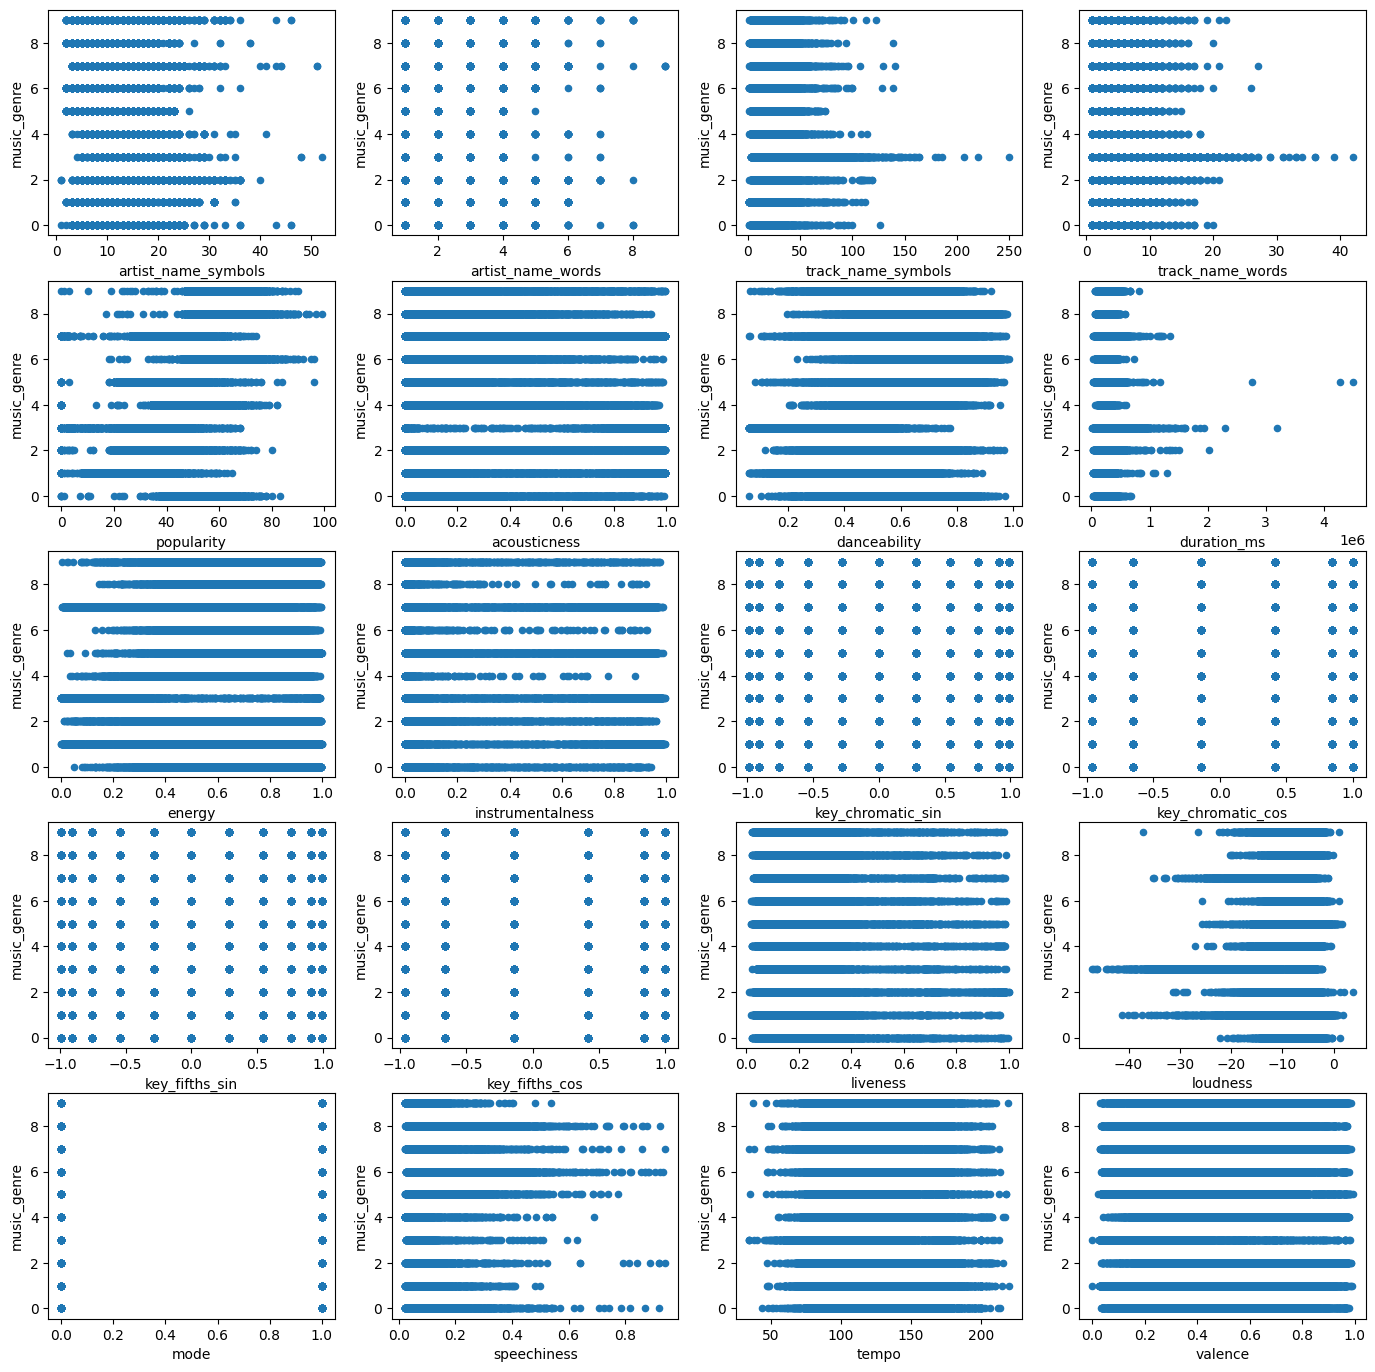

In [152]:
feature_index = df.columns.get_loc("music_genre")
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(17, 17))
for idx, feature in enumerate(df.columns[:feature_index]):
    df.plot(feature, "music_genre", subplots=True,  ax=axes[idx // 4, idx % 4], kind="scatter")

Оставим графики, где есть что-то интересное

In [153]:
interesting = [0,1,2,3,4,6,7,8,15,17]

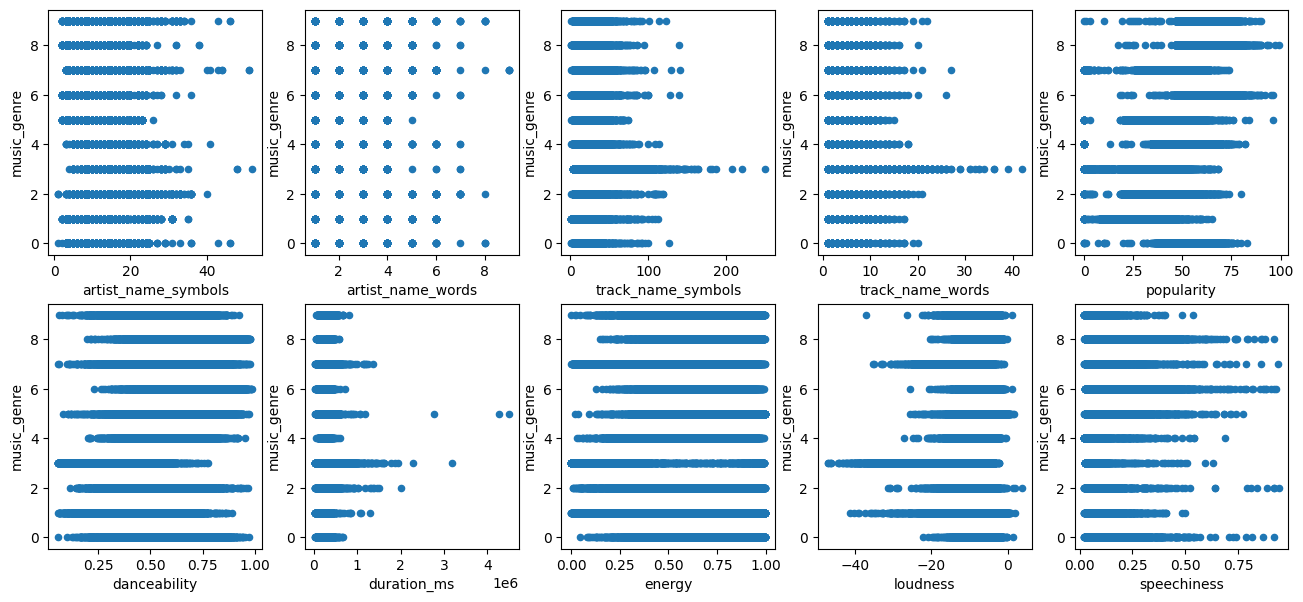

In [154]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 7))
for idx, feature in enumerate(df.columns[interesting]):
    df.plot(feature, "music_genre", subplots=True,  ax=axes[idx // 5, idx % 5], kind="scatter")

In [155]:
for i in range(df["music_genre"].unique().shape[0]):
  print(i,le.inverse_transform([i]), end = "\t")

0 ['Alternative']	1 ['Anime']	2 ['Blues']	3 ['Classical']	4 ['Country']	5 ['Electronic']	6 ['Hip-Hop']	7 ['Jazz']	8 ['Rap']	9 ['Rock']	

Что мы тут увидели интересного:
*   Есть жанры, у которых число символов и слов в названии исполнителя не бывает длиннее определенного порога, например, Электронная музыка, Аниме.
*    Есть жанры, у которых нет популярности выше определенного порога
* Самые длинные треки у классической музыки и электронной
* Уровень громкости бывает низким у классики, аниме и джаза. Ну, видимо, признак того, что эти жанры бывает принято записывать так. Звучит логично

## Box plots

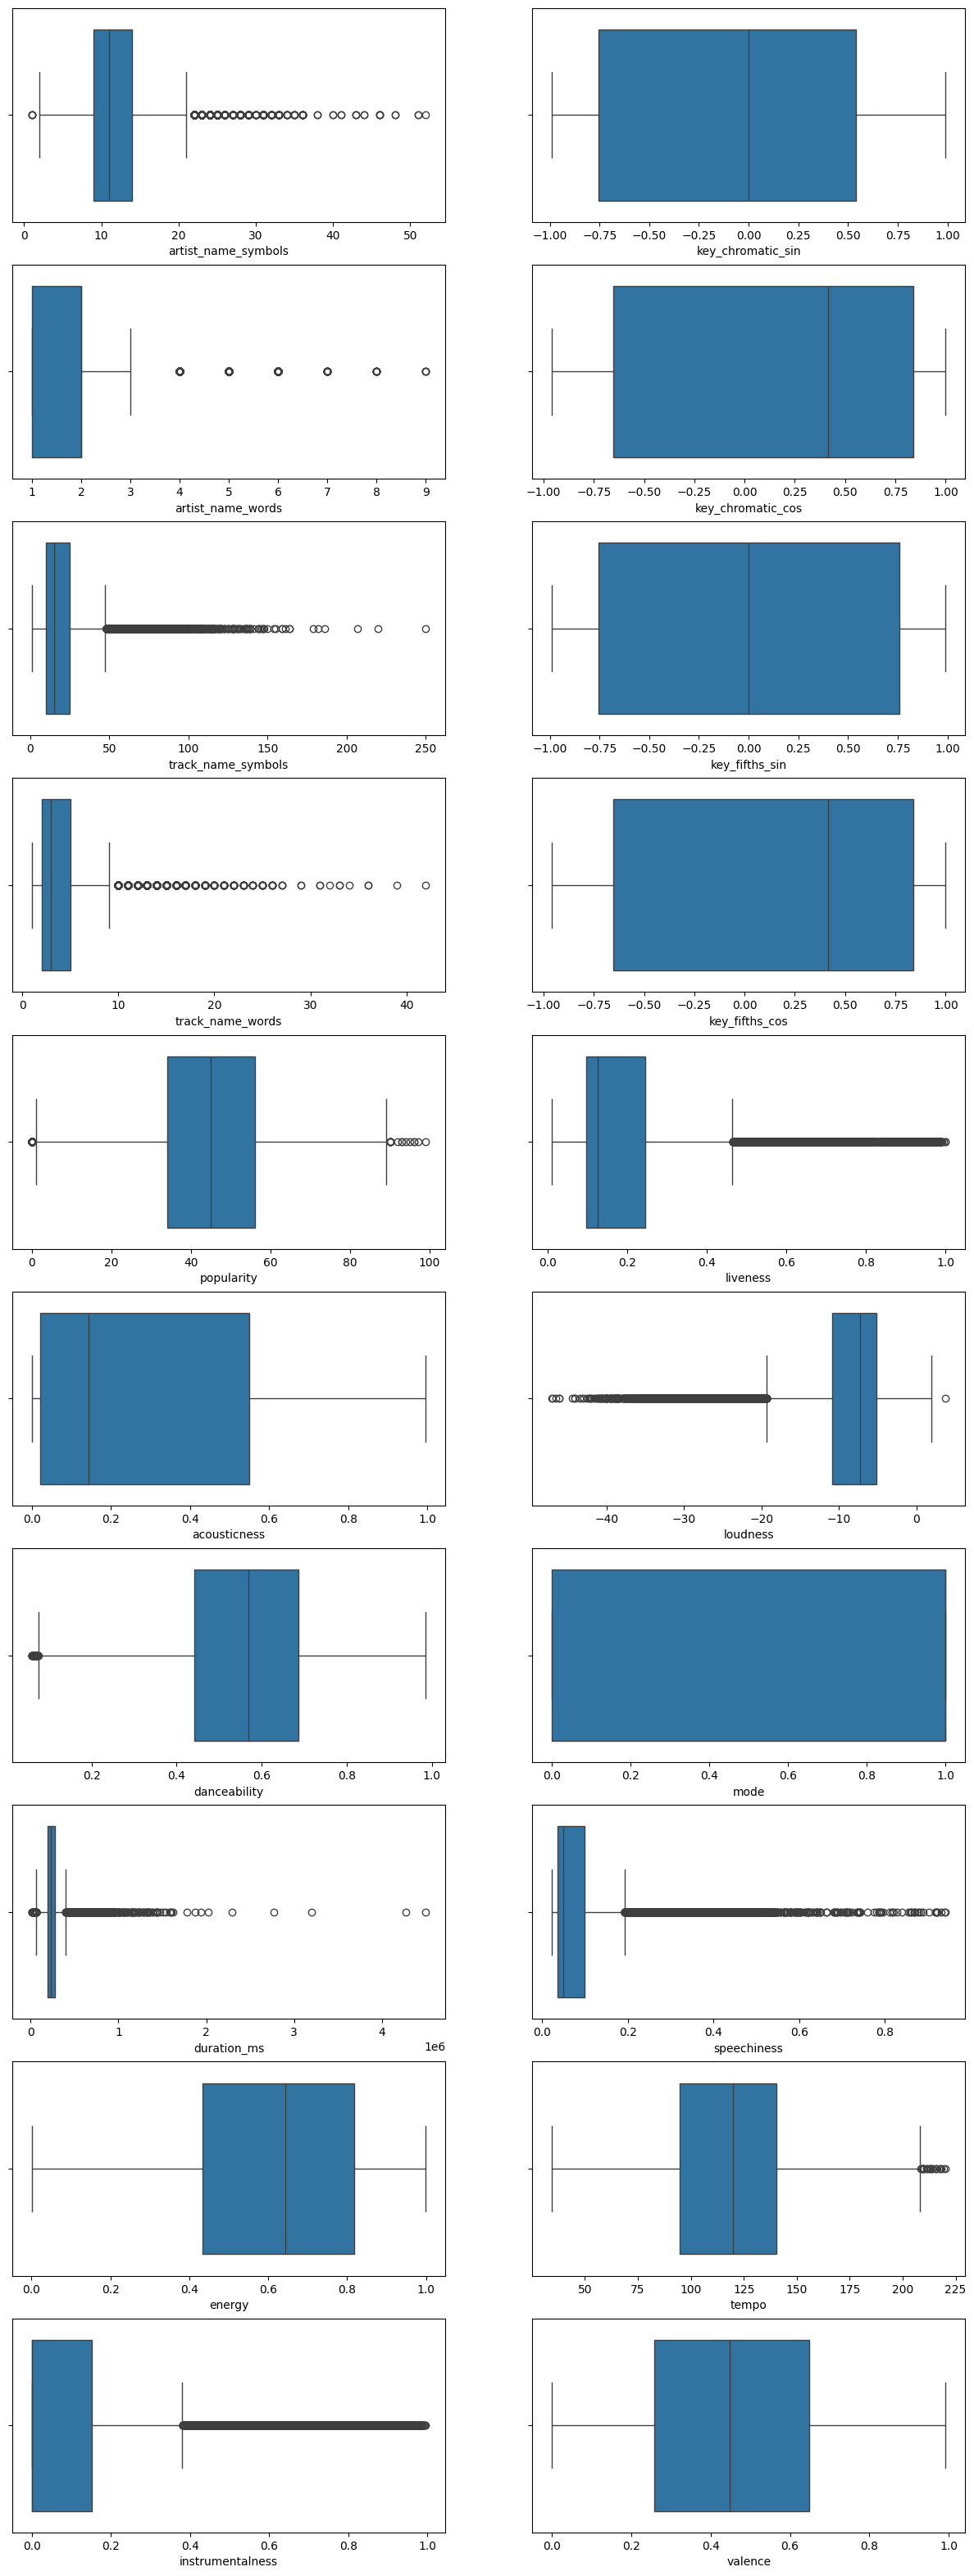

In [156]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 40))
count = 0
for idx, feature in enumerate(df.columns[:feature_index]):
    sns.boxplot(x=df[feature], ax=axes[count % 10, count // 10])
    count += 1

Меня, конечно, смущает, что есть параметры, для которых выбросов достаточно много. К сожалению, я не знаю, по каким принципам считались параметры типа instrumentalness, но, их статистика выглядит странновато. Но, признаков, где есть именно странные выбросы, я не вижу

Посмотрим сначала распределения

И у меня вообще говоря нет уверенности, что они должны подчиняться нормальному распределению

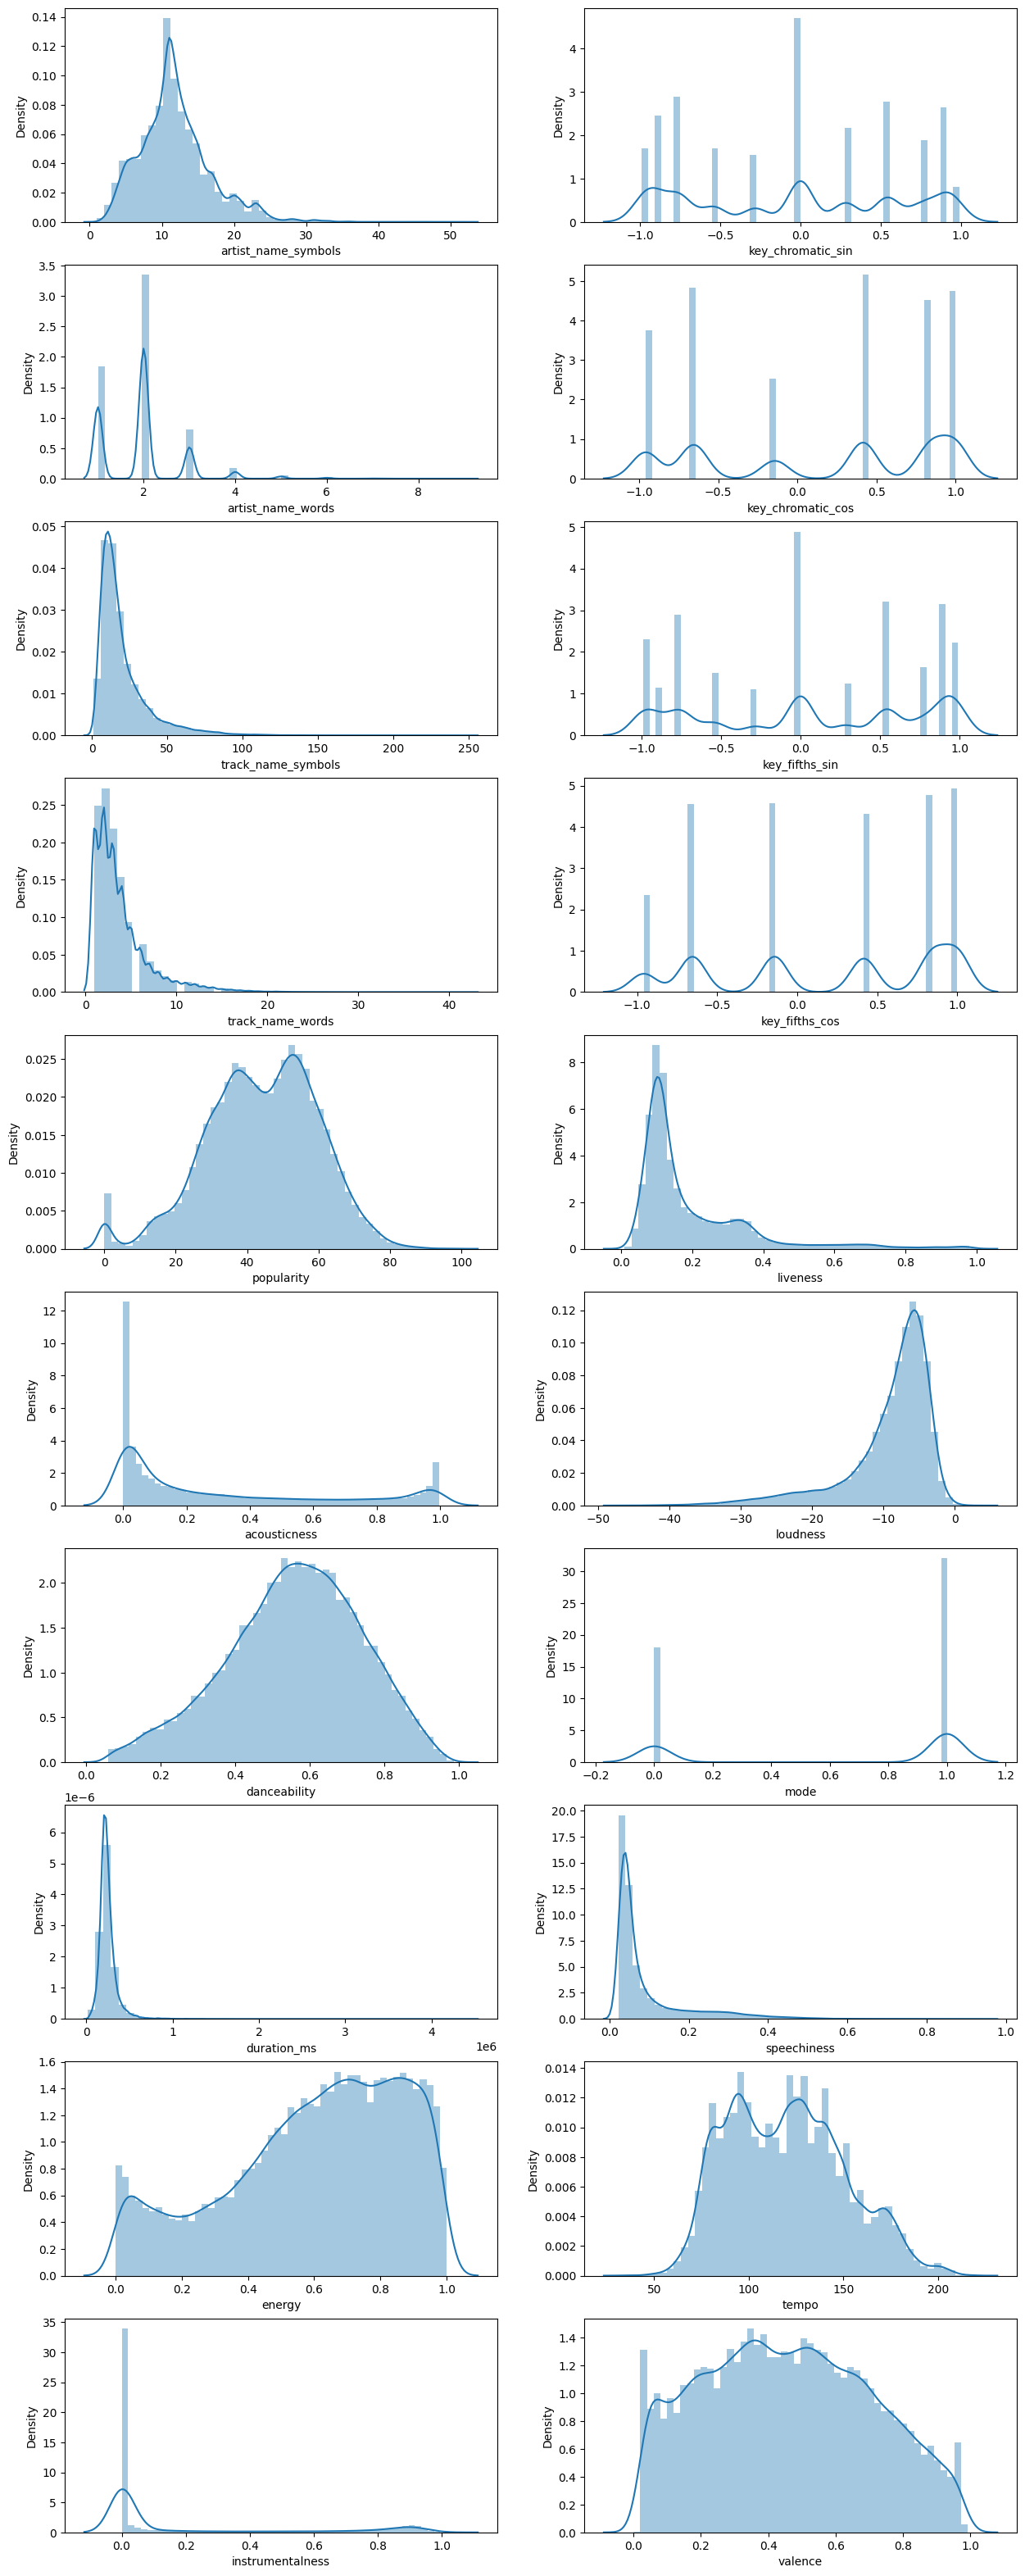

In [157]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(15, 40))
count = 0
for idx, feature in enumerate(df.columns[:feature_index]):
    sns.distplot(df[feature], bins=50, ax=axes[count % 10, count // 10])
    count += 1

## Корреляции

Давайте еще посмотрим на корреляции, и, уберем лишние признаки, если они есть

<Axes: >

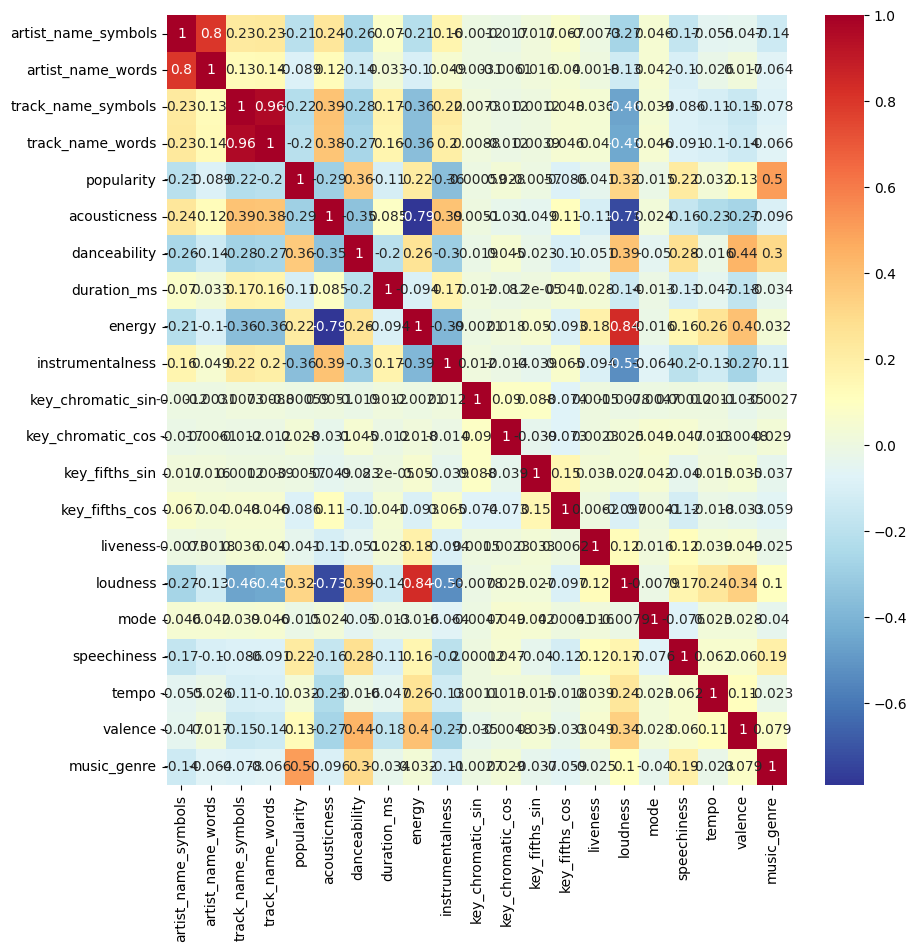

In [158]:
plt.figure(figsize=(10,10))
sns.heatmap(df.iloc[:, : feature_index+1].corr(), cmap="RdYlBu_r", annot=True)

В итоге, у нас сильно закоррелированы число слов и символов. Оставим, пожалуй, число символов.

Хорошая корреляция у loudness и energy, поскольку, в параметре energy лично я вижу больше смысла, то loudness убираем. О чем может говорить, более громкий трек считается более энергичным

Более того, у нас есть сильная отрицательная корреляция у energy и acousticness. Поскольку, у energy более приятное распределние, уберем acousticness

Также логично, что есть корреляция между жанром и популярностью

In [159]:
df_backup = df.copy()

df.drop('artist_name_words', inplace=True, axis=1)
df.drop('track_name_words', inplace=True, axis=1)
df.drop('acousticness', inplace=True, axis=1)
df.drop('loudness', inplace=True, axis=1)

## Выбросы

### Преобразование данных

Попробуем так же разные функции для преобразования данных

In [160]:
#ax = sns.boxplot(x=df['liveness'].apply(lambda x: math.log(x)))
def compareOutliers(feature_name, funct):
  outliers = [y for stat in boxplot_stats(df[feature_name]) for y in stat['fliers']]
  outliers_fn = [y for stat in boxplot_stats(df[feature_name].apply(lambda x: funct(x))) for y in stat['fliers']]

  return (len(outliers), len(outliers_fn))

In [161]:
df.columns

Index(['artist_name_symbols', 'track_name_symbols', 'popularity',
       'danceability', 'duration_ms', 'energy', 'instrumentalness',
       'key_chromatic_sin', 'key_chromatic_cos', 'key_fifths_sin',
       'key_fifths_cos', 'liveness', 'mode', 'speechiness', 'tempo', 'valence',
       'music_genre', 'x0_Alternative', 'x0_Anime', 'x0_Blues', 'x0_Classical',
       'x0_Country', 'x0_Electronic', 'x0_Hip-Hop', 'x0_Jazz', 'x0_Rap',
       'x0_Rock'],
      dtype='object')

In [162]:
features = ['artist_name_symbols', 'track_name_symbols', 'duration_ms', 'speechiness', 'liveness'] #'instrumentalness']

for ft in features:
  print(ft, compareOutliers(ft, math.log))

artist_name_symbols (1822, 2018)
track_name_symbols (2965, 375)
duration_ms (2401, 2273)
speechiness (5667, 515)
liveness (2626, 90)


In [163]:
features = ['artist_name_symbols', 'track_name_symbols', 'duration_ms', 'speechiness', 'instrumentalness', 'liveness']

for ft in features:
  print(ft, compareOutliers(ft, math.sqrt))

artist_name_symbols (1822, 1481)
track_name_symbols (2965, 1589)
duration_ms (2401, 2362)
speechiness (5667, 3958)
instrumentalness (8532, 410)
liveness (2626, 1768)


In [164]:
features = ['artist_name_symbols', 'track_name_symbols', 'duration_ms', 'speechiness','instrumentalness', 'liveness']

for ft in features:
  print(ft, compareOutliers(ft, lambda x: 1/(x+0.00001)))

artist_name_symbols (1822, 3401)
track_name_symbols (2965, 2738)
duration_ms (2401, 2220)
speechiness (5667, 0)
instrumentalness (8532, 0)
liveness (2626, 899)


<Axes: xlabel='speechiness', ylabel='Density'>

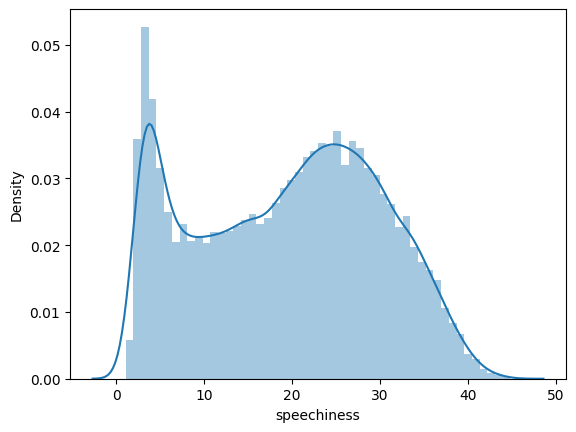

In [165]:
sns.distplot(df['speechiness'].apply(lambda x: 1/x), bins=50)

In [166]:
#я получил эту функцию после некоторой медитации :D
compareOutliers('instrumentalness', lambda x: math.sqrt(1/math.sqrt((x+0.001))))

(8532, 0)

Итого, liveness и track_name_symbols можно логарифмировать, что даже видно по графикам, для speechness берем 1/x, а для instrumentalness функцию еще немного хитрее

А artist_name_symbols вообще дропнем, это искусственный признак, ну, вышел плохой, с кучей выбросов, ну ладно

In [167]:
df['track_name_symbols'] = df['track_name_symbols'].apply(lambda x: math.log(x))
df['liveness'] = df['liveness'].apply(lambda x: math.log(x))
df['speechiness'] = df['speechiness'].apply(lambda x: 1/x)
df['instrumentalness'] = df['instrumentalness'].apply((lambda x: math.sqrt(1/math.sqrt((x+0.001)))))
df.drop('artist_name_symbols', inplace=True, axis=1)

In [168]:
compareOutliers('duration_ms', lambda x: math.log10(x))
stats = boxplot_stats(df['duration_ms'])
u = stats[0]['whishi']
df[df['duration_ms'] > u]["music_genre"].value_counts()

music_genre
3    868
7    381
5    332
2    278
9     96
0     71
1     58
8     36
6     36
4     17
Name: count, dtype: int64

У классической музыки слишком много треков с большой длительностью. Есть длительности, где нет других классов кроме как классической музыки. Я пока что тогда дропну этот признак, так как с ним надо очень аккуратно. Потом, если будет более сложная модель, могу снова включить

In [169]:
df.drop('duration_ms', inplace=True, axis=1)

## IQR

Удаляем выбросы по критерию IQR, удобно, что можно взять границы прямо из boxplot

In [170]:
prev = df.shape[0]
target_feature_index = df.columns.get_loc('music_genre')

for col in df.columns[:target_feature_index]:
  stats = boxplot_stats(df[col])
  l = stats[0]['whislo']
  u = stats[0]['whishi']

  if len(stats[0]['fliers']) == 0: continue

  df.drop(df[df[col] < l].index, inplace=True)
  df.drop(df[df[col] > u].index, inplace=True)

  print(col, len(stats[0]['fliers']))

print(prev, df.shape)

track_name_symbols 375
popularity 548
danceability 159
liveness 125
tempo 20
40560 (39333, 25)


О, отлично, отделались малой кровью, 1000 записей из 40000. Потом можно будет проверить, как все будет работать с RobustScaler без удаления выбросов

Дальше я воспользуюсь Standart scaler и не буду гадать


In [171]:
scaler = StandardScaler()
df_backup2 = df.copy()
df[df.columns[:target_feature_index]] = scaler.fit_transform(df[df.columns[:target_feature_index]])

## Визуализация с PCA

In [172]:
X = df[df.columns[:target_feature_index]].copy()
YL = df[df.columns[target_feature_index]].copy()
Yohe = df[df.columns[target_feature_index+1:]].copy()

In [173]:
model = PCA(n_components=2)
model.fit(X)
pca_coords = model.transform(X)

df_to_draw = pd.DataFrame({
    'class': YL,
    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
})
colors = ['b', 'r', 'k', 'g', 'c', 'm', 'y', 'gold', 'darkorange', 'lime']

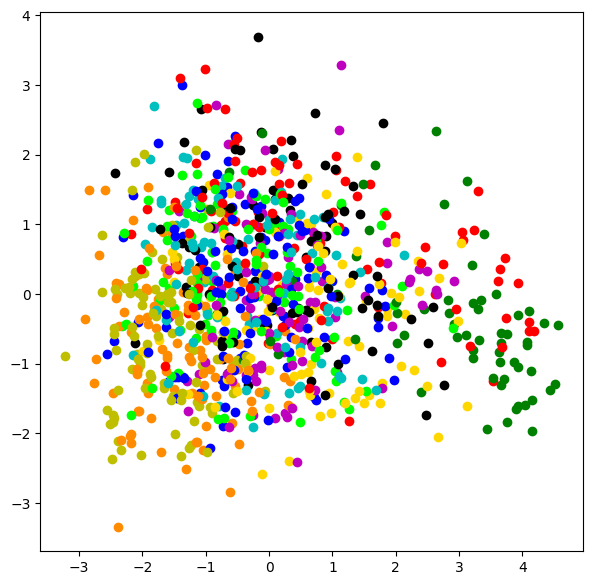

In [174]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
np.random.seed(8)

for f in df_to_draw.sample(1000).iterrows():
    ax.scatter(f[1]['pca1'], f[1]['pca2'], c=colors[int(f[1]['class'])])

plt.show()

Ну вот классическая музыка выделилась (зеленый)

In [175]:
YL.value_counts()

music_genre
9    4078
6    4041
7    4028
0    4019
8    4014
5    3993
4    3985
2    3944
1    3920
3    3311
Name: count, dtype: int64

## Метрика

Даже после нормализации у нас классы практически сбалансированы (кроме классической музыки, но и то не слишком существенно). Поскольку у нас задача многоклассовой классификации, будет F1 micro мера

# Бейзлайн

Выбираем логистическую регрессию

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, YL, random_state=8, test_size=0.25)

In [177]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train);
y_preds_dummy = dummy_clf.predict(X_test)
print(classification_report(y_test, y_preds_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       999
           1       0.00      0.00      0.00       939
           2       0.00      0.00      0.00       999
           3       0.00      0.00      0.00       827
           4       0.00      0.00      0.00       997
           5       0.00      0.00      0.00       970
           6       0.10      1.00      0.18       987
           7       0.00      0.00      0.00      1015
           8       0.00      0.00      0.00      1019
           9       0.00      0.00      0.00      1082

    accuracy                           0.10      9834
   macro avg       0.01      0.10      0.02      9834
weighted avg       0.01      0.10      0.02      9834



In [178]:
#неотмасштабированные данные без выбросов
X_train, X_test, y_train, y_test = train_test_split(df_backup2[df_backup2.columns[:df_backup2.columns.get_loc('music_genre')]], df_backup2['music_genre'], random_state=8, test_size=0.25)

In [179]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lg_model = LogisticRegression(multi_class='auto')
lg_model.fit(X_train, y_train)
y_preds_ovr = lg_model.predict(X_test)
print(classification_report(y_test, y_preds_ovr))

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       999
           1       0.63      0.67      0.65       939
           2       0.51      0.42      0.46       999
           3       0.78      0.78      0.78       827
           4       0.50      0.61      0.55       997
           5       0.54      0.59      0.57       970
           6       0.45      0.55      0.49       987
           7       0.48      0.42      0.45      1015
           8       0.45      0.37      0.41      1019
           9       0.54      0.61      0.57      1082

    accuracy                           0.53      9834
   macro avg       0.53      0.53      0.53      9834
weighted avg       0.52      0.53      0.52      9834



Итого, accuracy (то есть F1 micro) было 0.1, стало 0.53, вполне неплохо для начала

# ДЗ 2




Посмотрим на коэффициенты

In [180]:
lr_coeffs = pd.DataFrame(lg_model.coef_,columns = X.columns, index = le.classes_)
lr_coeffs

,track_name_symbols,popularity,danceability,energy,instrumentalness,key_chromatic_sin,key_chromatic_cos,key_fifths_sin,key_fifths_cos,liveness,mode,speechiness,tempo,valence
Alternative,-0.226493,0.870145,-0.046803,0.450697,0.026465,0.003359,-0.037083,0.040141,-0.017664,0.001216,-0.010314,0.133526,-0.020722,-0.213238
Anime,-0.502523,-4.106249,-0.832309,0.290523,-0.069563,0.038472,-0.021322,-0.086696,0.026767,-0.121223,-0.122113,0.404709,0.034522,0.069690
Blues,0.045660,-2.028286,-0.734943,-0.298861,-0.089682,-0.027097,0.011937,0.207714,0.149703,0.030912,0.041388,0.285286,-0.085846,0.869211
Classical,0.897822,-1.729551,-1.539381,-1.178770,-0.811450,0.059975,-0.002085,0.007681,-0.016009,-0.182982,-0.010648,-0.434686,-0.170130,0.267017
Country,0.097184,0.127837,0.167351,0.106354,1.095723,0.005292,-0.052812,0.160611,-0.047154,0.018253,0.496160,0.993228,0.208064,0.272298
Electronic,-0.011833,-1.269126,0.969278,0.855324,-1.003941,-0.021736,0.001651,-0.137316,-0.060508,0.033918,-0.197548,-0.020718,0.193751,-0.767461
Hip-Hop,-0.112126,2.773137,1.302577,0.078632,0.797196,-0.046541,0.056889,-0.070010,-0.052710,0.144064,-0.082509,-1.051075,0.004192,-0.571097
Jazz,-0.053343,-0.757312,-0.031884,-0.801266,-0.762671,0.001206,-0.000192,-0.249358,0.049676,-0.009344,-0.218230,-0.035411,-0.232111,0.503928
Rap,-0.143525,3.202495,1.129155,0.125411,0.770036,-0.035397,0.063375,-0.047935,-0.069591,0.115047,-0.076125,-0.916858,0.033948,-0.669721
Rock,0.009174,2.916911,-0.383040,0.371955,0.047887,0.022468,-0.020359,0.175170,0.037491,-0.029861,0.179938,0.641998,0.034331,0.239372


<Axes: >

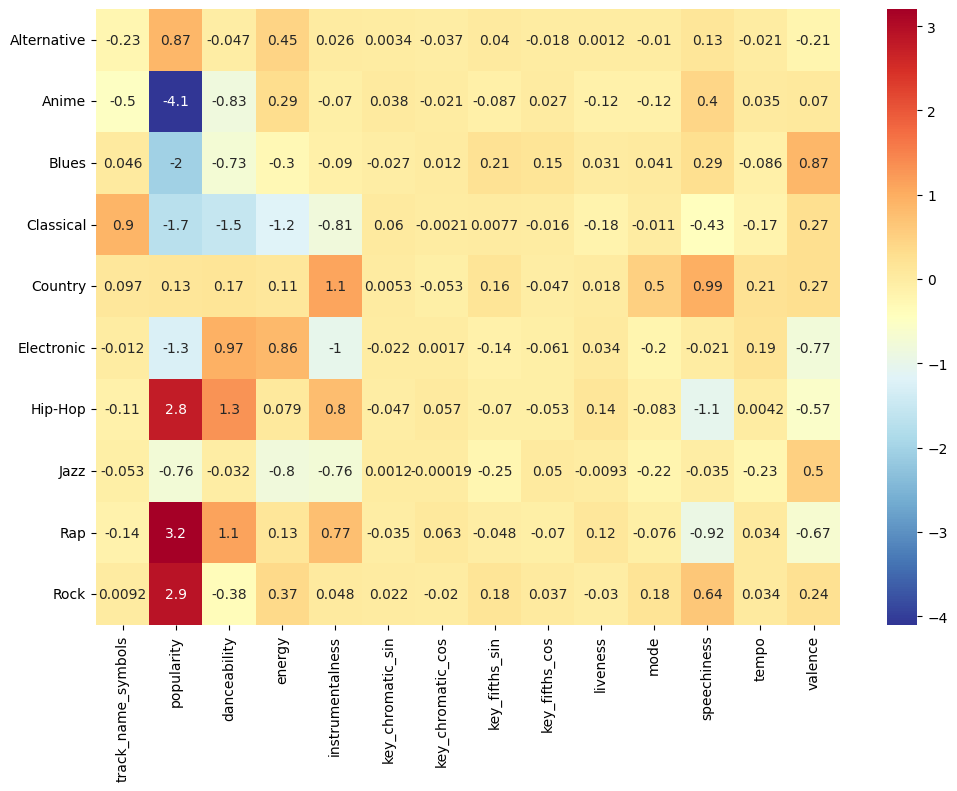

In [181]:
plt.subplots(figsize=(12,8))
sns.heatmap(lr_coeffs, cmap="RdYlBu_r",annot=True)

Что интересно, кварто-квинтовый круг все же используется в модели, а вот хроматический очень мало

In [182]:
lg_model.intercept_

array([ 1.49626341, -1.27256354,  0.8547208 , -1.36172464,  0.69512202,
        0.78677359, -1.16018856,  1.36245257, -1.32487327, -0.07598237])

# Оптимизация гиперпараметров

## Логистическая регрессия

In [183]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

parameters = {
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'random_state': [8],
}

grid_search = GridSearchCV(
    estimator=lg_model,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

Тут я код комменитрую, чтобы при перезапуске снова не запускались долгие вычисления, которыя я сделал уже у себя на локальной машине

А так, кросс валидация есть по умолчанию в grid_search

In [184]:
#grid_search.fit(X_train, y_train)
#best_parameters = grid_search.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(f"{param_name}: {best_parameters[param_name]}")
#y_pred_optimized = grid_search.best_estimator_.predict(X_test)
#print(classification_report(y_test, y_pred_optimized))

random_state: 8\
solver: saga

## k ближайших соседей

In [185]:
from sklearn.preprocessing import normalize

X_train, X_test, y_train, y_test = train_test_split(df_backup2[df_backup2.columns[:df_backup2.columns.get_loc('music_genre')]], df_backup2['music_genre'], random_state=8, test_size=0.25)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

normalize(X_train)
normalize(X_test)

array([[ 0.02262511,  0.1366507 ,  0.3237739 , ..., -0.10414746,
        -0.18862701,  0.32725153],
       [ 0.33715306,  0.08865654, -0.06774359, ...,  0.32650543,
         0.13535807, -0.03302078],
       [-0.18614902, -0.35227171, -0.09403339, ...,  0.12172723,
        -0.0124646 , -0.24317145],
       ...,
       [-0.00455624, -0.08090291,  0.19457499, ...,  0.41657426,
         0.09774349,  0.16930202],
       [ 0.36054426, -0.11153766,  0.02062439, ...,  0.45265791,
        -0.33274875, -0.10812184],
       [-0.03264186,  0.0010118 ,  0.26799513, ...,  0.26414458,
        -0.23138289,  0.53805227]])

In [186]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

parameters = {
    'n_neighbors': [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights' : ['uniform', 'distance'],
}

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=parameters,
    n_jobs=-1,
    verbose=1,
)

In [187]:
#grid_search.fit(X_train, y_train)

In [188]:
#best_parameters = grid_search.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(f"{param_name}: {best_parameters[param_name]}")
#y_pred_optimized = grid_search.best_estimator_.predict(X_test)
#print(classification_report(y_test, y_pred_optimized))

algorithm: brute\
n_neighbors: 23\
weights: uniform

## Дерево решений

In [189]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(df_backup2[df_backup2.columns[:df_backup2.columns.get_loc('music_genre')]], df_backup2['music_genre'], random_state=8, test_size=0.25)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

dtc = DecisionTreeClassifier()
parameters = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_weight_fraction_leaf' : [0,0.1,0.2,0.3],
    'max_features' : [None, 'sqrt','log2'],
    'random_state' : [8],
    'min_impurity_decrease' : [0,0.1,0.2],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12],
    'ccp_alpha' : [0,0.1,0.2,0.3,0.4,0.5]
}

grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=parameters,
    n_jobs=-1,
    verbose=1,
)

In [190]:
#grid_search.fit(X_train, y_train)
#best_parameters = grid_search.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print(f"{param_name}: {best_parameters[param_name]}")
#y_pred_optimized = grid_search.best_estimator_.predict(X_test)
#print(classification_report(y_test, y_pred_optimized))

Тут выход

ccp_alpha: 0 \
criterion: gini \
max_depth: 9 \
max_features: None \
min_impurity_decrease: 0 \
min_weight_fraction_leaf: 0 \
random_state: 8 \
splitter: best \

Теперь обучим все эти модели и зафиксируем точность. Ну и пусть нормализация будет везде, она не ухудшает остальное, а ближайшим соседям нужна конечно

In [191]:
X_train, X_test, y_train, y_test = train_test_split(df_backup2[df_backup2.columns[:df_backup2.columns.get_loc('music_genre')]], df_backup2['music_genre'], random_state=8, test_size=0.25)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
normalize(X_train_norm)
normalize(X_test_norm)

logreg = LogisticRegression(multi_class='auto', random_state = 8, solver = 'saga')
logreg.fit(X_train_norm, y_train)
y_preds_ovr = logreg.predict(X_test_norm)
print(classification_report(y_test, y_preds_ovr))

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       999
           1       0.63      0.67      0.65       939
           2       0.51      0.42      0.46       999
           3       0.78      0.78      0.78       827
           4       0.50      0.61      0.55       997
           5       0.54      0.59      0.57       970
           6       0.45      0.55      0.49       987
           7       0.48      0.42      0.45      1015
           8       0.45      0.37      0.41      1019
           9       0.54      0.61      0.57      1082

    accuracy                           0.53      9834
   macro avg       0.53      0.53      0.53      9834
weighted avg       0.52      0.53      0.52      9834



In [192]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth = 9, random_state = 8)
dtc.fit(X_train_norm, y_train)
y_preds_dtc = dtc.predict(X_test_norm)
print(classification_report(y_test, y_preds_dtc))

              precision    recall  f1-score   support

           0       0.37      0.34      0.35       999
           1       0.72      0.63      0.67       939
           2       0.52      0.38      0.44       999
           3       0.86      0.70      0.78       827
           4       0.48      0.54      0.51       997
           5       0.47      0.53      0.50       970
           6       0.39      0.32      0.35       987
           7       0.44      0.39      0.42      1015
           8       0.45      0.53      0.48      1019
           9       0.49      0.71      0.58      1082

    accuracy                           0.50      9834
   macro avg       0.52      0.51      0.51      9834
weighted avg       0.51      0.50      0.50      9834



О, вроде не переобучилось

In [193]:
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 23, weights = 'uniform')
knn.fit(X_train_norm, y_train)
y_preds_knn = knn.predict(X_test_norm)
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.28      0.28      0.28       999
           1       0.67      0.56      0.61       939
           2       0.48      0.38      0.43       999
           3       0.78      0.78      0.78       827
           4       0.42      0.63      0.51       997
           5       0.50      0.53      0.51       970
           6       0.38      0.51      0.44       987
           7       0.43      0.36      0.39      1015
           8       0.34      0.29      0.31      1019
           9       0.50      0.42      0.46      1082

    accuracy                           0.47      9834
   macro avg       0.48      0.47      0.47      9834
weighted avg       0.47      0.47      0.46      9834



# Ансамблирование моделей

## BaggingClassifier



In [207]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
bcf_svc = BaggingClassifier(estimator=SVC(), n_estimators=20, random_state=8, n_jobs = -1)
bcf_svc.fit(X_train_norm, y_train)
y_pred_bcf_svc = bcf_svc.predict(X_test_norm)
print(classification_report(y_test, y_pred_bcf_svc))

              precision    recall  f1-score   support

           0       0.39      0.34      0.36       999
           1       0.73      0.73      0.73       939
           2       0.59      0.51      0.55       999
           3       0.86      0.80      0.83       827
           4       0.54      0.60      0.57       997
           5       0.59      0.61      0.60       970
           6       0.43      0.56      0.48       987
           7       0.52      0.45      0.48      1015
           8       0.42      0.32      0.36      1019
           9       0.53      0.67      0.59      1082

    accuracy                           0.55      9834
   macro avg       0.56      0.56      0.56      9834
weighted avg       0.55      0.55      0.55      9834



Стандартный эстиматор в BaggingClassifier

In [210]:
bcf_d = BaggingClassifier(n_estimators=20, random_state=8, n_jobs = -1)
bcf_d.fit(X_train_norm, y_train)
y_pred_bcf_d = bcf_d.predict(X_test_norm)
print(classification_report(y_test, y_pred_bcf_d))

              precision    recall  f1-score   support

           0       0.35      0.34      0.35       999
           1       0.74      0.72      0.73       939
           2       0.54      0.51      0.52       999
           3       0.84      0.77      0.80       827
           4       0.53      0.55      0.54       997
           5       0.57      0.55      0.56       970
           6       0.33      0.37      0.35       987
           7       0.49      0.44      0.46      1015
           8       0.32      0.31      0.32      1019
           9       0.50      0.61      0.55      1082

    accuracy                           0.51      9834
   macro avg       0.52      0.52      0.52      9834
weighted avg       0.51      0.51      0.51      9834



Немного улучшило, да

In [214]:
bcf_log_reg = BaggingClassifier(estimator=logreg, n_estimators=20, random_state=8, n_jobs = -1)
bcf_log_reg.fit(X_train_norm, y_train)
y_pred_bcf_log_ref = bcf_log_reg.predict(X_test_norm)
print(classification_report(y_test, y_pred_bcf_log_ref))

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       999
           1       0.63      0.67      0.65       939
           2       0.51      0.43      0.47       999
           3       0.78      0.78      0.78       827
           4       0.50      0.61      0.55       997
           5       0.55      0.58      0.56       970
           6       0.45      0.55      0.49       987
           7       0.48      0.42      0.45      1015
           8       0.46      0.37      0.41      1019
           9       0.54      0.60      0.57      1082

    accuracy                           0.53      9834
   macro avg       0.53      0.53      0.53      9834
weighted avg       0.52      0.53      0.52      9834



## Случайный лес

In [227]:
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators': np.arange(10, 160, 20),
    'max_depth': list(range(3, 13)) + [None],
    'random_state': [8],
    'criterion' : ['gini', 'entropy', 'log_loss'],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    n_jobs=-1,
    verbose=1,
    cv=3,
)

In [228]:
%%time

grid_search.fit(X_train_norm, y_train)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 264 candidates, totalling 792 fits
criterion: entropy
max_depth: 9
n_estimators: 110
random_state: 8
CPU times: total: 5.89 s
Wall time: 1min 32s


In [230]:
y_pred_optimized = grid_search.best_estimator_.predict(X_test_norm)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

           0       0.45      0.25      0.32       999
           1       0.72      0.73      0.72       939
           2       0.60      0.46      0.52       999
           3       0.85      0.79      0.82       827
           4       0.53      0.59      0.56       997
           5       0.57      0.60      0.58       970
           6       0.42      0.57      0.48       987
           7       0.56      0.41      0.48      1015
           8       0.42      0.28      0.34      1019
           9       0.48      0.83      0.61      1082

    accuracy                           0.55      9834
   macro avg       0.56      0.55      0.54      9834
weighted avg       0.55      0.55      0.54      9834



## Stacking Classifier

In [237]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier

estimators = [('logrer', logreg),('svr', LinearSVC(dual="auto", random_state=8)), ('dtc',dtc), ('knn',knn),
             ('rf', RandomForestClassifier(n_estimators=110, random_state=8,max_depth = 9, criterion = 'entropy')),
             ('bag',bcf_svc)]

stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(),n_jobs = -1)

stack_clf.fit(X_train_norm, y_train)
y_pred_stack_clf = stack_clf.predict(X_test_norm)
print(classification_report(y_test, y_pred_stack_clf))


              precision    recall  f1-score   support

           0       0.42      0.35      0.38       999
           1       0.76      0.74      0.75       939
           2       0.62      0.53      0.57       999
           3       0.88      0.78      0.83       827
           4       0.57      0.59      0.58       997
           5       0.59      0.61      0.60       970
           6       0.45      0.56      0.50       987
           7       0.54      0.47      0.50      1015
           8       0.46      0.38      0.42      1019
           9       0.52      0.74      0.61      1082

    accuracy                           0.57      9834
   macro avg       0.58      0.57      0.57      9834
weighted avg       0.57      0.57      0.57      9834



Не ну две сотых выжать это мощно, да)) Но работает

In [240]:
!pip install catboost  > None

In [260]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=20000,
                           learning_rate=0.05,
                           depth=2,
                           loss_function='MultiClass',
                          metric_period=500)
# Fit model
model.fit(X_train_norm, y_train)
# Get predicted classes
y_pred_cat = model.predict(X_test_norm)
print(classification_report(y_test, y_pred_cat))

0:	learn: 2.2556507	total: 5.05ms	remaining: 1m 40s
500:	learn: 1.1113720	total: 1.47s	remaining: 57.3s
1000:	learn: 1.0626999	total: 2.91s	remaining: 55.3s
1500:	learn: 1.0418318	total: 4.34s	remaining: 53.5s
2000:	learn: 1.0272809	total: 5.77s	remaining: 51.9s
2500:	learn: 1.0157908	total: 7.19s	remaining: 50.3s
3000:	learn: 1.0058967	total: 8.62s	remaining: 48.8s
3500:	learn: 0.9975512	total: 10.1s	remaining: 47.5s
4000:	learn: 0.9899041	total: 11.5s	remaining: 46.1s
4500:	learn: 0.9836611	total: 13s	remaining: 44.6s
5000:	learn: 0.9769702	total: 14.4s	remaining: 43.2s
5500:	learn: 0.9711517	total: 15.8s	remaining: 41.8s
6000:	learn: 0.9654823	total: 17.3s	remaining: 40.3s
6500:	learn: 0.9603661	total: 18.7s	remaining: 38.9s
7000:	learn: 0.9553918	total: 20.2s	remaining: 37.5s
7500:	learn: 0.9505887	total: 21.6s	remaining: 36s
8000:	learn: 0.9458513	total: 23.1s	remaining: 34.6s
8500:	learn: 0.9412320	total: 24.5s	remaining: 33.2s
9000:	learn: 0.9369826	total: 26s	remaining: 31.8s
9

Тоже 0.57
Там полно параметров, я понимаю, как их можно перебрать, но, поскольку это учебный проект, оставим так

# Интерпретация модели

In [262]:
!pip install shap > None

Shap пока что не поддерживает stacking classifier, а вот catboost нормально

In [277]:
import shap
explainer = shap.TreeExplainer(model)
explainer.class_names=le.classes_

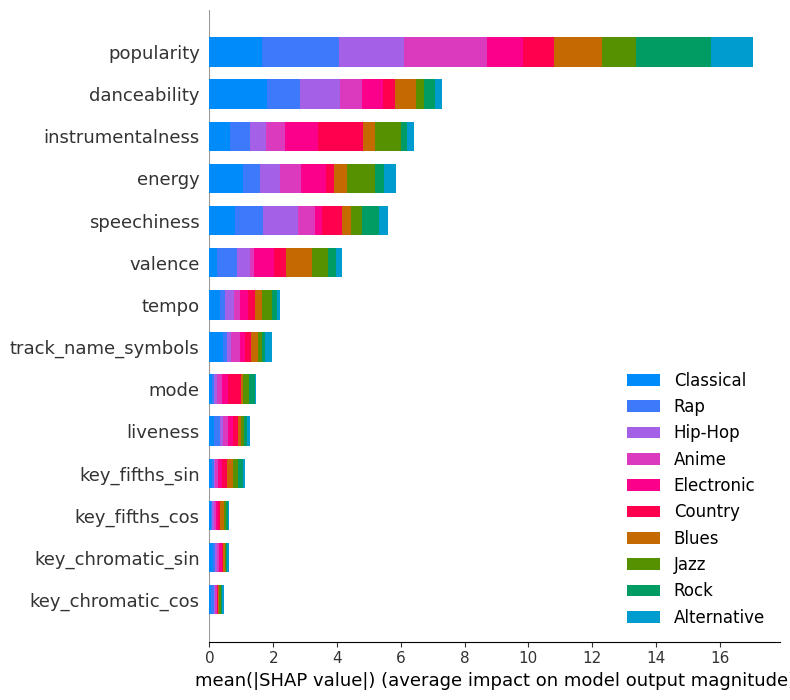

In [290]:
a = df_backup2[df_backup2.columns[:df_backup2.columns.get_loc('music_genre')]]
X_res = pd.DataFrame(X_test_norm,columns = a.columns)
#
shap_values = explainer.shap_values(X_res)
shap.summary_plot(shap_values, X_res, class_names = le.classes_)

В итоге, один из самых полезных признаков - это популярность песни, она делает в среднем наиболший вклад в разные жанры

Далее, danceability разделяет некоторые классы, и, больше всего, классическую музыку, если посмотреть на графики ниже. Логично, как мы знаем, классика она не про танцы и грув)

Затем, идут instrumentalness, energy и speechiness, что тоже соответствует моим представлениям о музыке, так как эти параметры естественно указывают на жанры

Для электроники один из характерных признаков - низкая "инструментальность", что действительно хорошо отличает это жанр

Для джаза характерна низкая "энергичность" и низкая популярность. Вообще согласен с оценкой вектора Шепли

Но то, что наибольший вклад имеет популярность, это иронично. Можно задуматься о смысле и природе слова "жанр", ну ладно. Но, действительно, рассмотреными моделями сложно добиться высокой метрики, поскольку деления на жанры зачастую условны. Вообще, интересно было бы натравить на датасет классификатор и посмотреть, какие бы классы выделила модель, а не сложившиеся традиции в нашей культуре

Также, логично, что тональность песни особо не различает жанры. Из забавного, количество символов в названии песни имеет среднее значение вектора Шепли сопоставимое с ритмом. Вклад есть, но не высокй. Разве что для элетронной музыки

Alternative


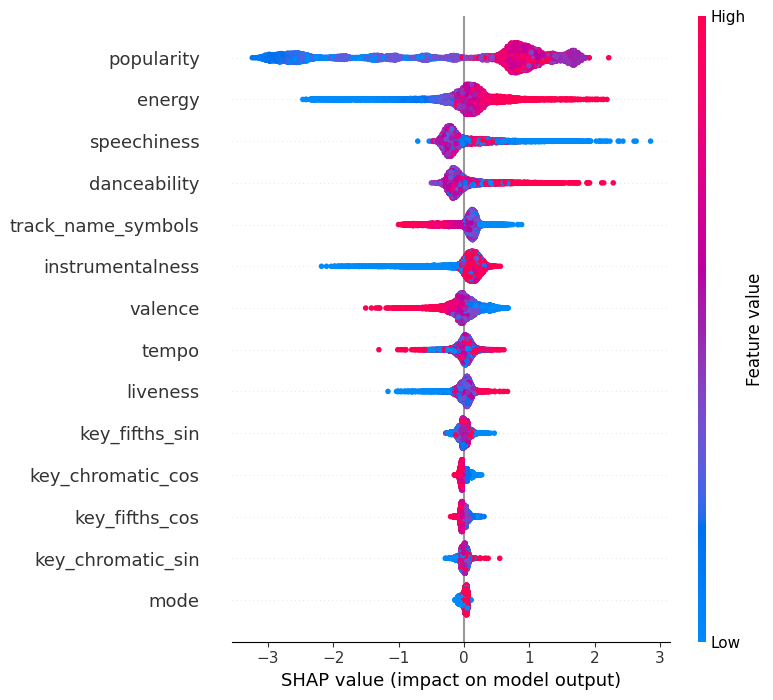

Anime


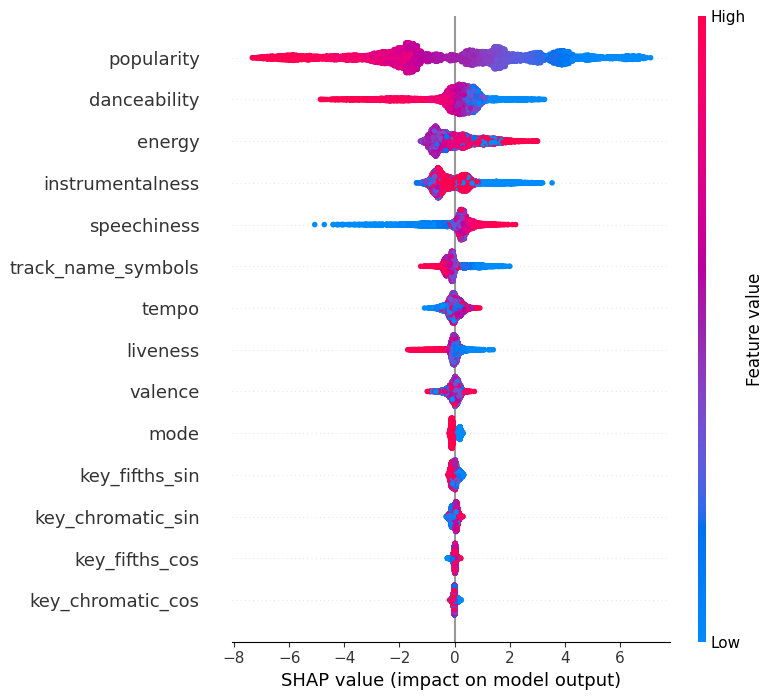

Blues


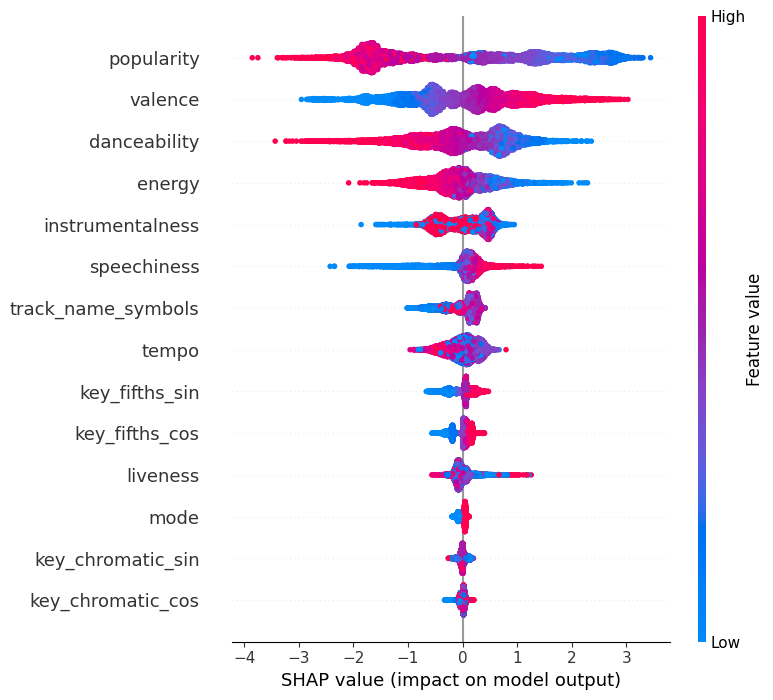

Classical


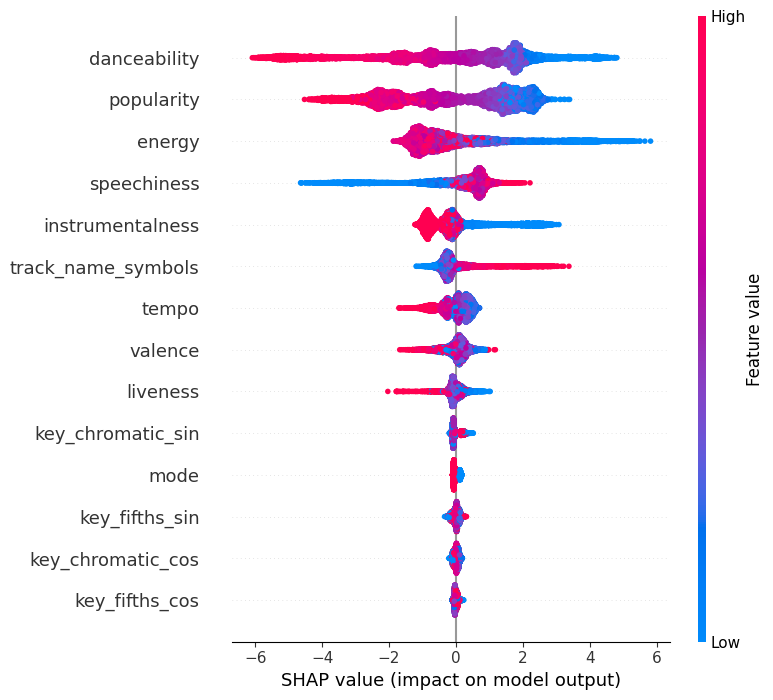

Country


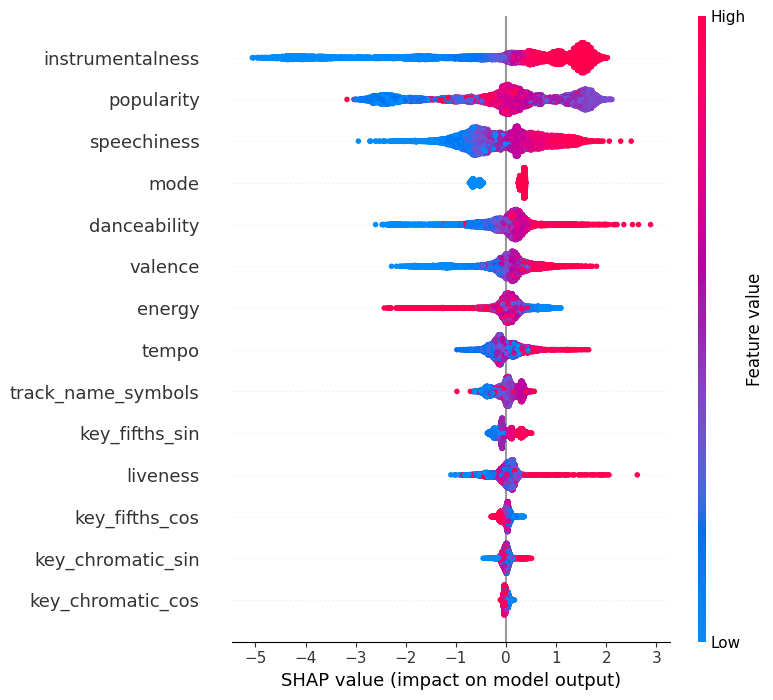

Electronic


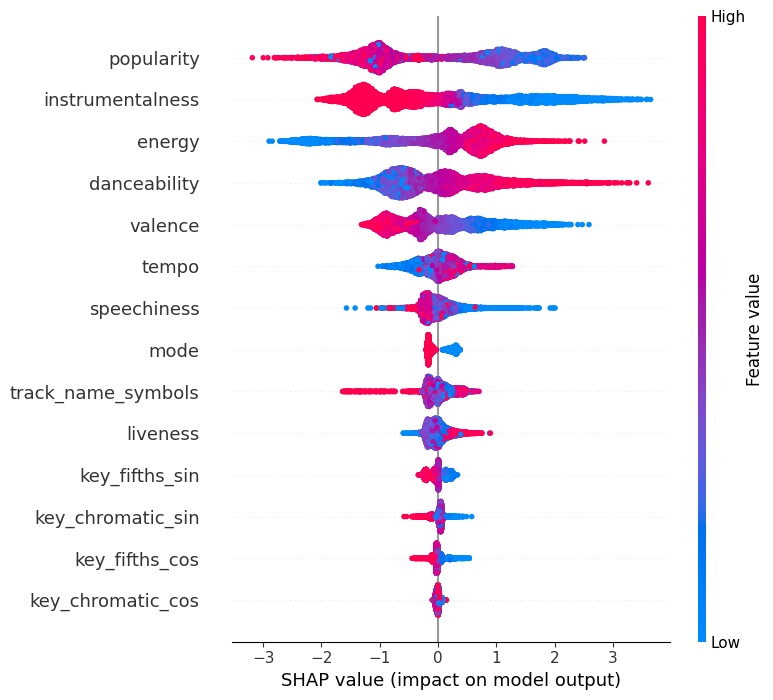

Hip-Hop


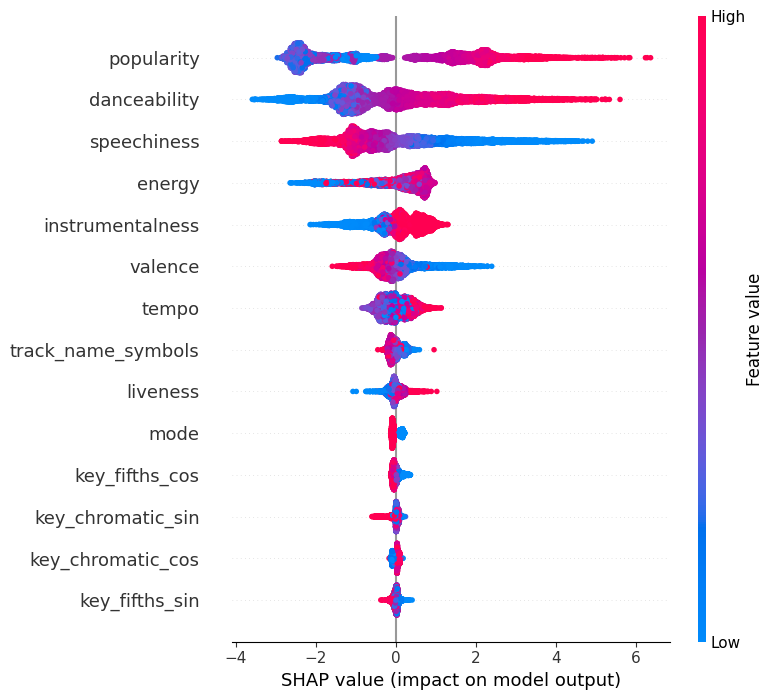

Jazz


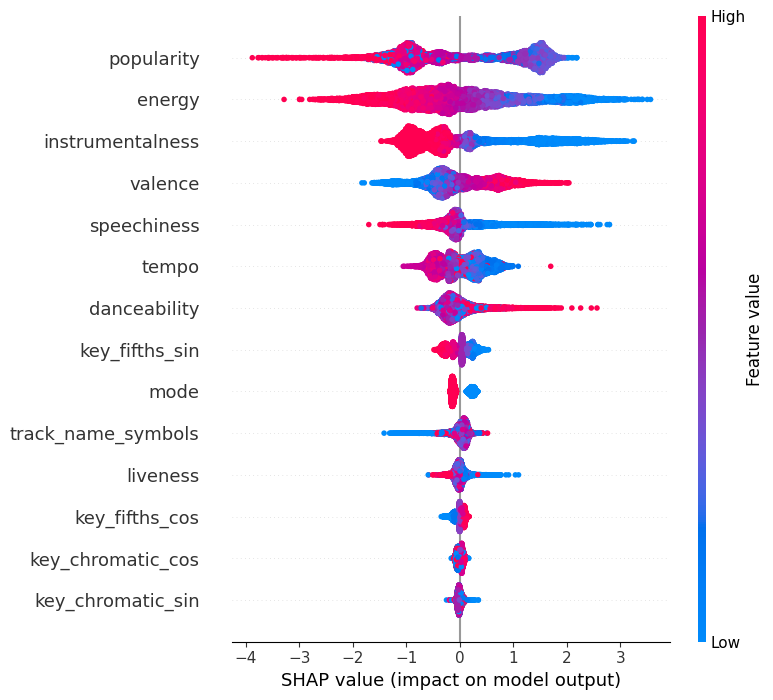

Rap


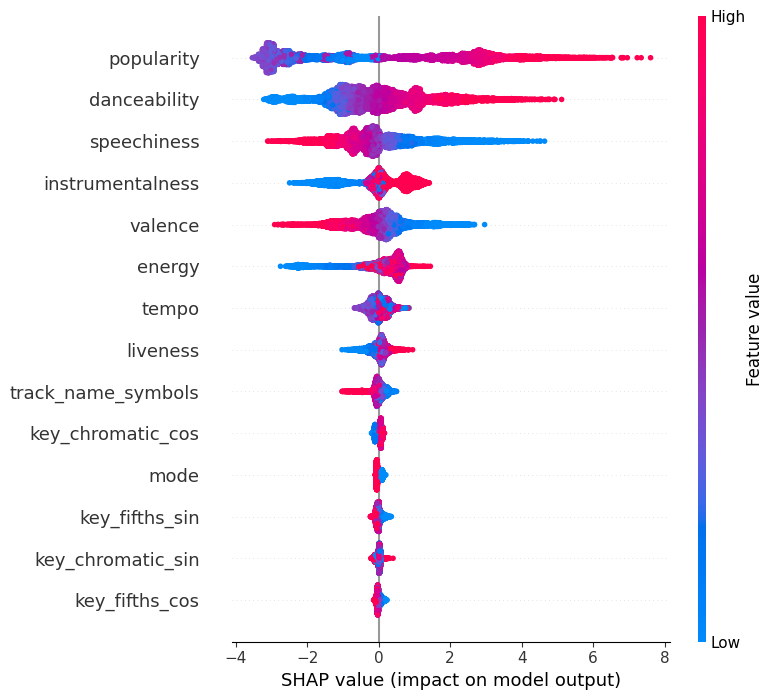

Rock


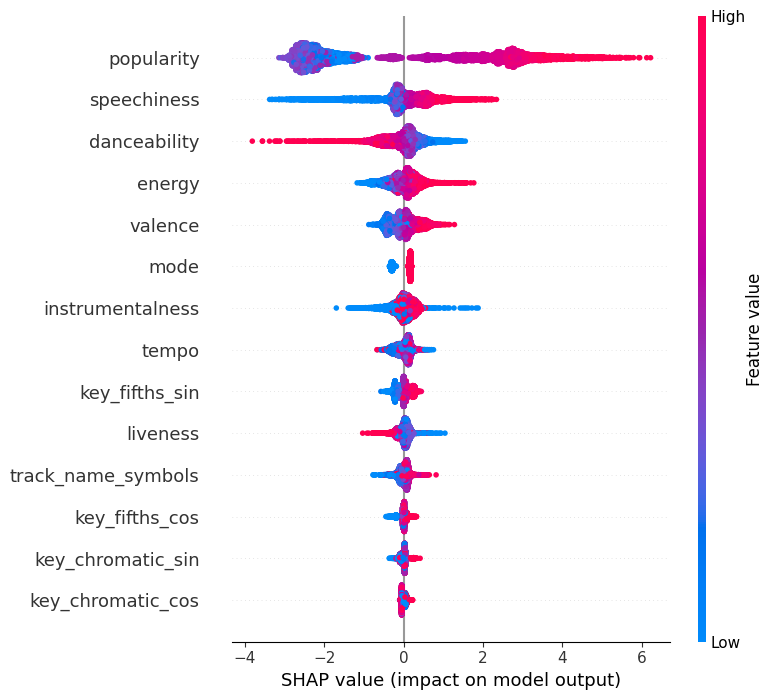

In [299]:
for i in range(len(le.classes_)):
    print(le.classes_[i])
    shap.summary_plot(shap_values[i], X_res)